The dataset for this BINARY CLASSIFIER to be used is [bc-dataset.csv].
There are 2 implementations here:
1. Bag of words approach.
2. **Word vectors (can be pre-trained word embeddings).**

The dataset split is 60-40.
Evaluation metrics to be used in this are:
1. Precision.
2. Recall.
3. F-Measure.

Loads the dataset.

In [1]:
from ftfy import fix_encoding
import pandas as pd
import numpy as np
import re
import csv
import string 
import nltk as nlp
from nltk.corpus import stopwords

nlp.download("stopwords")
nlp.download('punkt')
nlp.download('wordnet')

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def fix_encode(x):
    return fix_encoding(x)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

df = pd.read_csv(
    "datasets/bc-dataset.csv",
    encoding="latin1",
    sep=",",
    quoting=csv.QUOTE_ALL
)

data = pd.concat([df.gender, df['gender:confidence'], df.description], axis=1)

#drop null rows
data.shape

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(20050, 3)

# DATA PREPROCESSING

This section does the following:
1. Drops any rows containing NaN values in either the *description* or *gender* column.
2. Drops any rows containing the string 'brand' in *gender*.
3. Drops any rows containing values < **0.80** in the *gender:confidence* columm.
4. Resets the index.

In [2]:
data.dropna(subset=['description', 'gender'], inplace=True)
data = data.reset_index(drop=True)

data.drop(data[data['gender'] == 'brand'].index, inplace=True)
data = data.reset_index(drop=True)

data.drop(data[data['gender:confidence'] < 0.80].index, inplace=True)
data.drop('gender:confidence', axis=1, inplace=True)
data = data.reset_index(drop=True)

data.shape

(8847, 2)

Get the rows for *male* and *female* genders.

This section does the following to the text:
1. Fixes any broken encoding (via *ftfy*) that might have occurred when loading the file.
2. Removes the URL.
3. Removes HTML tags.
4. Removes emojis.
5. Removes punctuation.

In [3]:
data.description = data.description.apply(lambda x: fix_encode(x))

data['description']=data['description'].apply(lambda x : remove_URL(x))
data['description']=data['description'].apply(lambda x : remove_html(x))
data['description']=data['description'].apply(lambda x : remove_emoji(x))
data['description']=data['description'].apply(lambda x : remove_punct(x))
data.shape

(8847, 2)

In [4]:
print("ORIGINAL: ", data.description.iloc[5211])

ORIGINAL:  Owner of Itty Bitty the Pitty Scholar Writer Activist Unapologetic Fat Lady 


This section does the following to the text to finish off data preprocessing on the *description* column:
1. Cleans unnecessary characters.
2. Converts all string to lowercase.
3. Splits by tokenizing.
4. Deletes stopwords from the array.
5. Lemmatizes the words. 
6. Joins them.
7. Appends them to ```description_list``` array.

In [5]:
lemma = nlp.WordNetLemmatizer()
description_list = []

for each in data.description:
    each = re.sub("[^a-zA-Z]"," ", str(each))                                        
    each = each.lower()                                                              
    each = nlp.word_tokenize(each)                                                   
    each = [word for word in each if not word in set(stopwords.words("english"))]    
    each = [lemma.lemmatize(word) for word in each]                                  
    each = " ".join(each)                                                           
    # each = correct_spellings(each)                                                   # correct the spelling (?)
    description_list.append(each)                                                    

data.shape

(8847, 2)

In [6]:
len(description_list)

8847

In [7]:
print("ORIGINAL: ", data.description.iloc[5232])
print("PREPROCESSED: ", description_list[5232])

ORIGINAL:  We are all Stardust
PREPROCESSED:  stardust


Converts all instances of female into value 0, and 1 for male.

In [8]:
data.gender = [0 if gender == 'female' else 1 for gender in data.gender]

data['gender'].value_counts(ascending=True)

1    4227
0    4620
Name: gender, dtype: int64

# MODEL BUILDING

Uses ```CountVectorizer()``` to implement Bag-of-Words. The ``MAX_FEATURES`` variable determines the maximum number of features to be used during implementation.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

MAX_FEATURES = 5000

count_vectorizer = CountVectorizer(max_features=MAX_FEATURES, stop_words='english')
sparse_matrix = count_vectorizer.fit_transform(description_list).toarray()
words = count_vectorizer.get_feature_names()

In [43]:
print(words[50:100])

['adult', 'advance', 'adventure', 'adventurer', 'adventurous', 'advertising', 'advice', 'adviser', 'advisor', 'advocacy', 'advocate', 'ae', 'aesthetic', 'af', 'afc', 'affair', 'affiliate', 'affiliated', 'aficionado', 'afraid', 'africa', 'african', 'afternoon', 'ag', 'age', 'agency', 'agent', 'agile', 'agree', 'agreement', 'aha', 'ahead', 'ahs', 'aim', 'aint', 'air', 'airplane', 'aka', 'al', 'alabama', 'album', 'ale', 'alex', 'alfie', 'alias', 'alien', 'alive', 'allah', 'allaround', 'alliance']


The train-test split is 60-40.

In [10]:
from sklearn.model_selection import train_test_split

X = sparse_matrix
y = data.gender.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

# TRAINING & EVALUATION

In [11]:
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

## Random Forest Classifier

In [12]:
rfc = RandomForestClassifier(n_estimators = 100)

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [13]:
# mean accuracy
rfc.score(X_test, y_test)

0.6385984741452387

In [14]:
# y pred
y_pred_rfc = rfc.predict(X_test)

In [15]:
cm = confusion_matrix(y_test, y_pred_rfc)

f_measure = f1_score(y_test, y_pred_rfc, average="weighted")
precision_measure = precision_score(y_test, y_pred_rfc, average="weighted")
recall_measure = recall_score(y_test, y_pred_rfc, average="weighted")

print("F1 Score:", f_measure*100)
print("Precision:", precision_measure*100)
print("Recall:", recall_measure*100)


F1 Score: 63.67994680026639
Precision: 63.85209610805469
Recall: 63.85984741452388


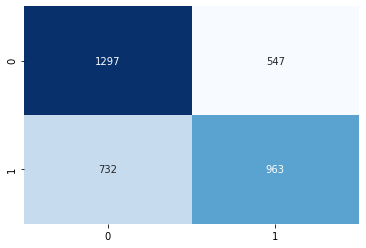

In [16]:
# for confusion matrix
sns.heatmap(cm, cbar=False, annot=True, cmap="Blues", fmt="d")
plt.show()

## Naive Bayes Model

### Multinomial NB

In [17]:
from collections import defaultdict
# from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB


nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

f_measure_nb = f1_score(y_test, y_pred_nb, average="weighted")
precision_measure_nb = precision_score(y_test, y_pred_nb, average="weighted")
recall_measure_nb = recall_score(y_test, y_pred_nb, average="weighted")

print("Mean accuracy: ", nb.score(X_test, y_test))
print("F-measure: ", f_measure_nb)
print("Precision: ", precision_measure_nb)
print("Recall: ", recall_measure_nb)


Mean accuracy:  0.6645945182254874
F-measure:  0.6617629833781742
Precision:  0.666067246384434
Recall:  0.6645945182254874


### Gaussian NB

In [18]:
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)

y_pred_gnb = gnb_classifier.predict(X_test)

print(classification_report(y_test, y_pred_nb, digits=5))
print("Mean accuracy: ", gnb_classifier.score(X_test, y_test))
print("WEIGHTED F-measure: ", f1_score(y_test, y_pred_nb, average="weighted"))
print("WEIGHTED Precision: ", precision_score(y_test, y_pred_gnb, average="weighted"))
print("WEIGHTED Recall: ", recall_score(y_test, y_pred_gnb, average="weighted"))

              precision    recall  f1-score   support

           0    0.65635   0.74783   0.69911      1844
           1    0.67663   0.57404   0.62113      1695

    accuracy                        0.66459      3539
   macro avg    0.66649   0.66094   0.66012      3539
weighted avg    0.66607   0.66459   0.66176      3539

Mean accuracy:  0.61514552133371
WEIGHTED F-measure:  0.6617629833781742
WEIGHTED Precision:  0.6267671457522654
WEIGHTED Recall:  0.61514552133371


## Logistic Regression

In [21]:
# Logistic Regression
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

f_measure_lr = f1_score(y_test, y_pred_lr, average="weighted")
precision_measure_lr = precision_score(y_test, y_pred_lr, average="weighted")
recall_measure_lr = recall_score(y_test, y_pred_lr, average="weighted")

print("Mean accuracy: ", lr.score(X_test, y_test))
print("F-measure: ", f_measure_lr)
print("Precision: ", precision_measure_lr)
print("Recall: ", recall_measure_lr)

Mean accuracy:  0.6555524159367053
F-measure:  0.6506759775295113
Precision:  0.6589370303636944
Recall:  0.6555524159367053


## Support Vector Machines

In [20]:
SVM = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto')
SVM.fit(X_train,y_train)

y_pred_svm = SVM.predict(X_test)

f_measure_svm = f1_score(y_test, y_pred_svm, average="weighted")
precision_measure_svm = precision_score(y_test, y_pred_svm, average="weighted")
recall_measure_svm = recall_score(y_test, y_pred_svm, average="weighted")

print("Mean accuracy: ", SVM.score(X_test, y_test))
print("F-measure: ", f_measure_svm)
print("Precision: ", precision_measure_svm)
print("Recall: ", recall_measure_svm)

C:\Users\LENOVO\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean accuracy:  0.5210511443910709
F-measure:  0.35698246712135784
Precision:  0.2714942950712446
Recall:  0.5210511443910709
